### Ejemplo juguete DAS OMP

In [174]:
import numpy as np
import pandas as pd
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.feature_selection import mutual_info_classif

#### Definir diccionario

In [175]:
### Dictionary
def dictionary_WPT(samples=1024, max_level=6, mother_wavelet='db4'):
    import pywt
    from sklearn.preprocessing import normalize
    # Base signal
    signal = np.zeros(samples)

    # Base tree
    wp_original = pywt.WaveletPacket(data=signal, wavelet=mother_wavelet, mode='periodization', maxlevel=max_level)

    dictionary = []
    dictionary_columns = []

    for level in range(1, max_level + 1):
        nodes = wp_original.get_level(level, order='natural')
        #print(f"Nivel {level}:")
        for node in nodes:
            #print(f"  Nodo: {node.path}, longitud: {len(node.data)}")
            dictionary_columns.append([node.path, len(node.data)])
            for i in range(len(node.data)):
                # New Tree
                wp_temp = pywt.WaveletPacket(data=None, wavelet=mother_wavelet, mode='periodization', maxlevel=max_level)

                # Zero Coefficients
                for other_node in wp_original.get_level(level, order='natural'):
                    wp_temp[other_node.path] = np.zeros_like(other_node.data)

                # One coefficient
                impulse = np.zeros_like(node.data)
                impulse[i] = 1
                wp_temp[node.path] = impulse

                # Rebuild signal (atom)
                signal_rec = wp_temp.reconstruct(update=False)

                # Normalize L2
                norm = np.linalg.norm(signal_rec)
                if norm > 0:
                    signal_rec /= norm

                dictionary.append(signal_rec)

    dictionary = np.array(dictionary)
    dictionary = normalize(dictionary, axis=1) 
    return dictionary_columns, dictionary

In [176]:
## Create Dictionary
coef_dictionary, D = dictionary_WPT()
atom, samples = D.shape
print('Shape dictionary', D.shape)

Shape dictionary (6144, 1024)


#### Función para crear señales sintéticas

[13, 26, 929, 1418, 2304, 2771, 2781, 2853, 3116, 3887, 4391, 5484]


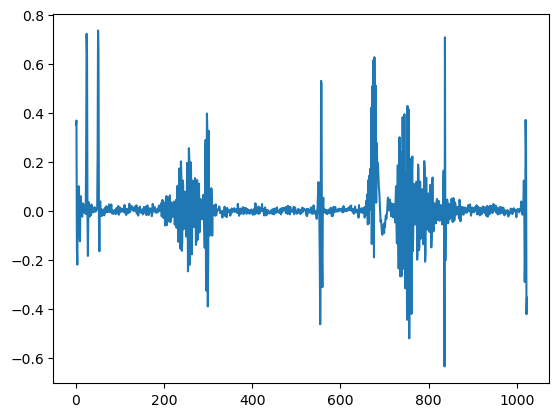

(1, 1024)


In [177]:
def signals_class(num_atoms, dictionary, num_signals):
    atom, samples = D.shape
    atomos = []
    for i in range(num_atoms):
        atomos.append(np.random.randint(atom))
    
    signal = np.zeros((samples))
    for atomo in atomos:
        signal+=dictionary[atomo]
    
    print(sorted(atomos))
    ## Señales fijas
    t = np.linspace(0, 1, samples)

    signals = []
    for i in range(num_signals):
        amp1 = np.random.uniform(0.1, 1.0)           # amplitud entre 0.1 y 1.0
        freq1 = np.random.uniform(1, 20)             # frecuencia entre 1 y 20 Hz
        s1 = amp1 * np.sin(2 * np.pi * freq1 * t)   
        
        amp2 = np.random.uniform(0.1, 1.0)
        freq2 = np.random.uniform(20, 100)           # frecuencia entre 20 y 100 Hz
        s2 = amp2 * np.cos(2 * np.pi * freq2 * t)
        
        ruido = np.random.randn(samples)
        
        signals.append(signal + 0.01*ruido)# + s1 + s2 + ruido)
 
    return np.array(signals)


data = signals_class(12,D,1)

plt.figure()
plt.plot(data[0])
plt.show()

print(data.shape)

### OMP

In [178]:
### OMP
def omp(x, D, T):
    """
    x: signal to represent (n,)
    D: dictionary (n x K)
    T: sparsity level
    Returns:
        alpha: sparse coefficient vector (K,)
    """
    n, K = D.shape
    #print(n, K, x.shape)
    r = x.copy()
    support = []
    alpha = np.zeros(n)

    for _ in range(T):
        # 1. Proyecciones
        projections = D @ r   # correlación con cada átomo

        scores = np.abs(projections)

        # 3. Evitar reselección de átomos ya elegidos
        scores[support] = -np.inf

        # 4. Elegir átomo con score máximo
        j_star = np.argmax(scores)
        support.append(j_star)

        # 5. Resolver mínimos cuadrados para soporte actual
        D_sub = D.T[:, support]
        alpha_sub = np.linalg.pinv(D_sub) @ x

        # 6. Actualizar residuo
        r = x - D_sub @ alpha_sub

    # 7. Guardar coeficientes en posiciones del soporte
    alpha[support] = alpha_sub

    return alpha, support

#### Crear señales sintéticas

In [179]:
clase_1 = signals_class(120, D, 40)
y_1 = np.zeros((40))
clase_2 = signals_class(120, D, 40)
y_2 = np.ones((40))

X = np.concatenate((clase_1, clase_2))
y = np.concatenate((y_1, y_2))

print(X.shape, y.shape)
print(y)

[108, 150, 203, 252, 262, 331, 344, 351, 375, 436, 482, 614, 798, 816, 823, 864, 915, 961, 967, 1000, 1012, 1054, 1058, 1195, 1196, 1218, 1228, 1243, 1262, 1319, 1363, 1371, 1382, 1423, 1433, 1434, 1439, 1452, 1589, 1636, 1742, 1809, 1839, 1937, 1967, 1968, 2105, 2308, 2404, 2447, 2489, 2635, 2650, 2661, 2690, 2866, 2936, 3063, 3077, 3080, 3086, 3119, 3122, 3127, 3132, 3167, 3297, 3360, 3414, 3726, 3734, 3744, 3779, 3820, 3828, 3893, 3992, 4065, 4072, 4137, 4167, 4241, 4296, 4373, 4483, 4529, 4562, 4582, 4605, 4661, 4835, 4899, 4950, 4979, 5013, 5051, 5267, 5304, 5350, 5426, 5449, 5466, 5473, 5485, 5534, 5576, 5585, 5705, 5706, 5711, 5741, 5751, 5765, 5782, 5816, 5889, 5996, 6034, 6089, 6110]
[57, 61, 67, 155, 278, 279, 312, 351, 442, 523, 593, 713, 734, 744, 744, 746, 839, 847, 885, 887, 900, 951, 1023, 1046, 1098, 1134, 1160, 1325, 1330, 1405, 1445, 1446, 1447, 1460, 1472, 1508, 1547, 1623, 1655, 1742, 1768, 1772, 1889, 1957, 2031, 2135, 2173, 2185, 2494, 2501, 2624, 2625, 2689, 2704

#### Crear grupos test y train

In [180]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print('X_train size:',X_train.shape,'X_test size:',X_test.shape,'y_train size:',len(y_test),'y_test size:',len(y_train))

X_train size: (64, 1024) X_test size: (16, 1024) y_train size: 16 y_test size: 64


### DAS - OMP

Representación Rala

In [ ]:
# Representación Rala

T = 10      # nivel de dispersión

alpha_c1 = []
alpha_c2 = []
support_c1 = []
support_c2 = []

# Alpha y soporte de cada señal por clase
for trial,clase in zip(X_train,y_train):
    alpha_temp, support_temp = omp(trial, D, T)
    if clase == 0:
        alpha_c1.append(alpha_temp)
        support_c1.append(support_temp)
    else:
        alpha_c2.append(alpha_temp)
        support_c2.append(support_temp)


Frecuencia de activación

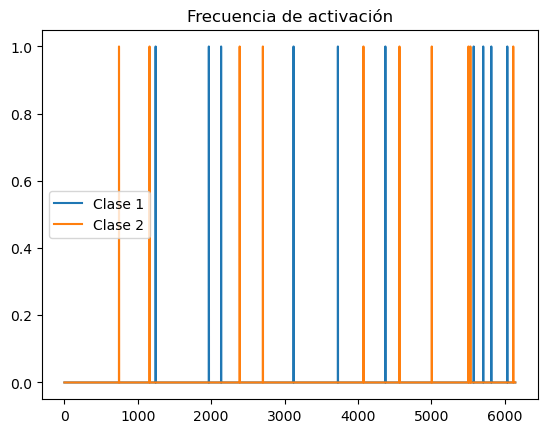

In [193]:
K = D.shape[0]  # número de átomos
frq_c1 = np.zeros(K)
frq_c2 = np.zeros(K)

# Clase 1
for support in support_c1:          # cada support es una lista de índices activos
    frq_c1[support] += 1
frq_c1 /= len(support_c1)           # normalizamos

# Clase 2
for support in support_c2:
    frq_c2[support] += 1
frq_c2 /= len(support_c2)

plt.figure()
plt.title('Frecuencia de activación')
plt.plot(frq_c1, label='Clase 1')
plt.plot(frq_c2, label='Clase 2')
plt.legend()

Magnitud del coeficiente